Este es el primer intento en usar una red neuronal en Keras con todos los datos de `train`

In [1]:
%matplotlib inline

import pandas as pd
import keras
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('seaborn-darkgrid')
plt.rc('font', size=12)


from matplotlib import rcParams
rcParams['figure.figsize'] = 15,6

from keras.models import Sequential, Model
from keras.layers import Input, Embedding, Dense, Activation, Dropout, Flatten, GRU
from keras import regularizers 
import keras
import keras.backend as K
from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau

from sklearn.preprocessing import MinMaxScaler

Using TensorFlow backend.


In [2]:
train = pd.read_csv('nuevo_train.csv', index_col=0, parse_dates=['timestamp'])

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 509376 entries, 103088 to 103582
Data columns (total 26 columns):
timestamp               509376 non-null datetime64[ns]
consumption             509376 non-null float64
temperature             280687 non-null float64
monday_is_day_off       509376 non-null int64
tuesday_is_day_off      509376 non-null int64
wednesday_is_day_off    509376 non-null int64
thursday_is_day_off     509376 non-null int64
friday_is_day_off       509376 non-null int64
saturday_is_day_off     509376 non-null int64
sunday_is_day_off       509376 non-null int64
large                   509376 non-null int64
medium                  509376 non-null int64
small                   509376 non-null int64
x-large                 509376 non-null int64
x-small                 509376 non-null int64
xx-large                509376 non-null int64
xx-small                509376 non-null int64
high                    509376 non-null int64
low                     509376 non-null int

In [4]:
train.drop(['temperature'], axis=1, inplace=True)

In [5]:
indices = train.index.unique().values
indices.sort()

In [6]:
train.head(10)

,timestamp,consumption,monday_is_day_off,tuesday_is_day_off,wednesday_is_day_off,thursday_is_day_off,friday_is_day_off,saturday_is_day_off,sunday_is_day_off,large,...,xx-small,high,low,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
series_id,,,,,,,,,,,,,,,,,,,,,
103088,2014-12-24 00:00:00,101842.233424,0,0,0,0,0,1,1,0,...,0,0,1,0,0,0,0,0,0,1
103088,2014-12-24 01:00:00,105878.048906,0,0,0,0,0,1,1,0,...,0,0,1,0,0,0,0,0,0,1
103088,2014-12-24 02:00:00,91619.105008,0,0,0,0,0,1,1,0,...,0,0,1,0,0,0,0,0,0,1
103088,2014-12-24 03:00:00,94473.706203,0,0,0,0,0,1,1,0,...,0,0,1,0,0,0,0,0,0,1
103088,2014-12-24 04:00:00,96976.755526,0,0,0,0,0,1,1,0,...,0,0,1,0,0,0,0,0,0,1
103088,2014-12-24 05:00:00,109154.512346,0,0,0,0,0,1,1,0,...,0,0,1,0,0,0,0,0,0,1
103088,2014-12-24 06:00:00,91909.721222,0,0,0,0,0,1,1,0,...,0,0,1,0,0,0,0,0,0,1
103088,2014-12-24 07:00:00,100895.387051,0,0,0,0,0,1,1,0,...,0,0,1,0,0,0,0,0,0,1
103088,2014-12-24 08:00:00,99821.982004,0,0,0,0,0,1,1,0,...,0,0,1,0,0,0,0,0,0,1


Transforma `consumption` de cada `series_id` en logaritmo natural y luego los normaliza

In [7]:
for ind in indices:
    valores = train.loc[ind]['consumption'].values
    valores = np.log1p(valores)
    valores_scaled = MinMaxScaler(feature_range=(-1, 1))
    valores = valores_scaled.fit_transform(valores.reshape(-1, 1))
    train.loc[ind, 'consumption'] = valores

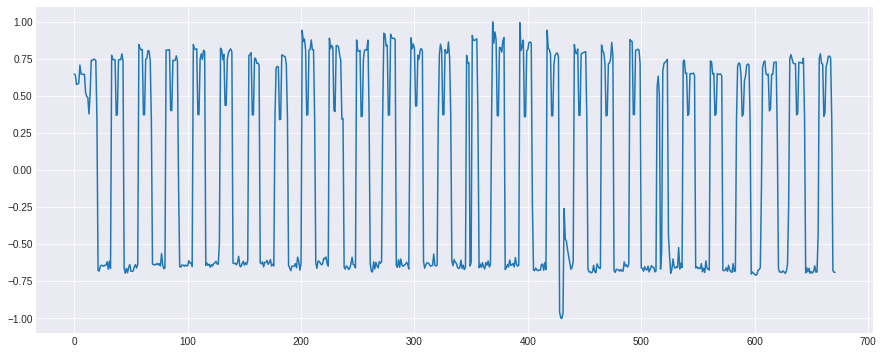

In [8]:
plt.figure(figsize=(15,6))
plt.plot(train.loc[indices[40],'consumption'].values)
plt.show()

In [9]:
split = 0.9
num_train = int(len(indices) * 0.9)
num_test = len(indices) - num_train

In [10]:
indices[-num_test:]

array([103235, 103244, 103245, 103246, 103249, 103261, 103263, 103264,
       103266, 103276, 103277, 103278, 103281, 103297, 103298, 103307,
       103310, 103320, 103321, 103322, 103324, 103331, 103334, 103346,
       103349, 103370, 103373, 103378, 103391, 103397, 103408, 103411,
       103412, 103417, 103424, 103425, 103428, 103430, 103432, 103436,
       103437, 103442, 103454, 103457, 103465, 103466, 103467, 103493,
       103496, 103498, 103501, 103502, 103503, 103510, 103517, 103536,
       103544, 103560, 103561, 103568, 103570, 103577, 103582, 103583,
       103585, 103595, 103596, 103600, 103605, 103607, 103611, 103621,
       103625, 103627, 103633, 103634])

In [11]:
train_df = train.loc[indices[:num_train]].copy()
test_df = train.loc[indices[-num_test:]].copy()

train_df = train_df.set_index('timestamp')
test_df = test_df.set_index('timestamp')

In [12]:
x_data = train_df.values

In [13]:
x_data.shape

(458304, 24)

In [14]:
y_data = train_df.consumption.values
y_data = y_data.reshape(-1, 1)

In [15]:
y_data.shape

(458304, 1)

In [16]:
num_x_signals = x_data.shape[1]
print(num_x_signals)
num_y_signals = y_data.shape[1]
print(num_y_signals)

24
1


In [17]:
def batch_generator(batch_size, sequence_length):
    """
    Generator function for creating random batches of training-data.
    """

    # Infinite loop.
    while True:
        # Allocate a new array for the batch of input-signals.
        x_shape = (batch_size, sequence_length, num_x_signals)
        x_batch = np.zeros(shape=x_shape, dtype=np.float16)

        # Allocate a new array for the batch of output-signals.
        y_shape = (batch_size, sequence_length, num_y_signals)
        y_batch = np.zeros(shape=y_shape, dtype=np.float16)

        # Fill the batch with random sequences of data.
        for i in range(batch_size):
            # Get a random start-index.
            # This points somewhere into the training-data.
            idx = np.random.randint(num_train - sequence_length)
            
            # Copy the sequences of data starting at this index.
            x_batch[i] = x_data[idx:idx+sequence_length]
            y_batch[i] = y_data[idx:idx+sequence_length]
        
        yield (x_batch, y_batch)

In [18]:
batch_size = 64
sequence_length = 24 * 7 * 1
sequence_length

168

In [19]:
generator = batch_generator(batch_size=batch_size,
                            sequence_length=sequence_length)

Aquí se define el modelo de Keras

In [32]:
def smape_error(y_true, y_pred):
    return K.mean(K.clip(K.abs(y_pred - y_true),  0.0, 1.0), axis=-1)


def get_model(num_x_signals, num_y_signals):
# Configuración del modelo

    dropout = 0.5
    regularizer = 0.00004
    main_input = Input(shape=(None, num_x_signals,), dtype='float32', name='main_input')
    #     site_input = Input(shape=(num_sites,), dtype='float32', name='site_input')
    #     access_input = Input(shape=(num_accesses,), dtype='float32', name='access_input')


    x0 = main_input
    x = Dense(200, activation='relu', 
              kernel_initializer='lecun_uniform', kernel_regularizer=regularizers.l2(regularizer))(x0)
    x = Dropout(dropout)(x)
    x = keras.layers.concatenate([x0, x])
    x = Dense(200, activation='relu', 
              kernel_initializer='lecun_uniform', kernel_regularizer=regularizers.l2(regularizer))(x)
    x = BatchNormalization(beta_regularizer=regularizers.l2(regularizer),
                           gamma_regularizer=regularizers.l2(regularizer)
                          )(x)
    x = Dropout(dropout)(x)
    x = Dense(100, activation='relu', 
              kernel_initializer='lecun_uniform', kernel_regularizer=regularizers.l2(regularizer))(x)
    x = Dropout(dropout)(x)

    x = Dense(200, activation='relu', 
              kernel_initializer='lecun_uniform', kernel_regularizer=regularizers.l2(regularizer))(x)
    x = Dropout(dropout)(x)
    x = Dense(num_y_signals, activation='linear', 
              kernel_initializer='lecun_uniform', kernel_regularizer=regularizers.l2(regularizer))(x)

    model =  Model(inputs=[main_input], outputs=[x])
    model.compile(loss=smape_error, optimizer='adam', metrics=['accuracy'])
    return model

In [33]:
path_checkpoint = 'primer_modelo.h5'
callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint,
                                      monitor='val_loss',
                                      verbose=1,
                                      save_weights_only=True,
                                      save_best_only=True)

In [34]:
callback_early_stopping = EarlyStopping(monitor='val_loss',
                                        patience=3, verbose=1)

In [35]:
callback_reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                       factor=0.1,
                                       min_lr=1e-4,
                                       patience=0,
                                       verbose=1)

In [36]:
callbacks = [callback_early_stopping,
             callback_checkpoint,
             callback_reduce_lr]

In [37]:
modelo2 = get_model(num_x_signals, num_y_signals)

In [ ]:
modelo2.fit_generator(generator=generator, epochs=50, steps_per_epoch=100, callbacks=callbacks, verbose=1)

Epoch 1/50
100/100 [==============================] - 19s 192ms/step - loss: 0.3677 - acc: 0.0108
Epoch 2/50
100/100 [==============================] - 19s 188ms/step - loss: 0.1459 - acc: 0.0151
Epoch 3/50
100/100 [==============================] - 20s 199ms/step - loss: 0.1236 - acc: 0.0151
Epoch 4/50
100/100 [==============================] - 19s 186ms/step - loss: 0.1106 - acc: 0.0156
Epoch 5/50
100/100 [==============================] - 18s 185ms/step - loss: 0.1012 - acc: 0.0157
Epoch 6/50
100/100 [==============================] - 19s 185ms/step - loss: 0.0947 - acc: 0.0152
Epoch 7/50
100/100 [==============================] - 19s 186ms/step - loss: 0.0899 - acc: 0.0154
Epoch 8/50
100/100 [==============================] - 19s 185ms/step - loss: 0.0858 - acc: 0.0159
Epoch 9/50
100/100 [==============================] - 19s 188ms/step - loss: 0.0817 - acc: 0.0157
Epoch 10/50
100/100 [==============================] - 19s 186ms/step - loss: 0.0785 - acc: 0.0152
Epoch 11/50
100/100

In [ ]:
# try:
#     model2.load_weights(path_checkpoint)
# except Exception as error:
#     print("Error trying to load checkpoint.")
#     print(error)

In [26]:
x_test = test_df.values
y_test = test_df.consumption.values

In [29]:
print('Tamaño de x_test: {}'.format(x_test.shape))
print('Tamaño de y_test: {}'.format(y_test.shape))

Tamaño de x_test: (1, 51072, 24)
Tamaño de y_test: (51072,)


In [28]:
x_test = np.expand_dims(x_test, axis=0)
print(x_test.shape)

result = modelo2.predict(x_test)

(1, 51072, 24)


In [29]:
result.shape

(1, 51072, 1)

In [ ]:
result = np.squeeze(result, axis=0)

In [ ]:
result.shape

In [ ]:
num_indice = 50

plt.plot(result[num_indice * 672:(num_indice + 1) * 672], label='Predicha')
plt.plot(y_test[num_indice * 672:(num_indice + 1) * 672], label='Verdadera')
plt.legend()
plt.show()